# REBER Grammar with RNN

This workbook follows the notebook regarding <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words. In this one we gonna train a more complexe RNN to generate Embedded Reber's word

## What is a Reber Word ?

The embedded version Reber word is a word following the graph:

<img src="embreber.gif"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

We discover on the previous notebook how to generate a dataset for the training. We just gonna change it to use Embedded Word

In [2]:
x, y = reber.get_one_embedded_example(minLength=10)
print(reber.sequenceToWord(x))

BTBTSSXXTTTTVPSET


In [3]:
reber.in_grammar(reber.sequenceToWord(x)[2:-1])

True

To generate the target, we can reuse the previous fonction to generate the output based on the input

In [4]:
def generate(x0):
    end = np.array([0.,  0.,  0.,  0.,  0.,  0.,  1.])
    y=x0[1:]
    y.append(end)
    return y

So now let's build our dataset. Due to the embedding features, the maxlen for the padding will be increase to 30

In [5]:
maxlen = 30
min_length = 10

X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []
y_possible = []

for i in range(2048):
    x, y = reber.get_one_embedded_example(minLength=min_length)
    X_train.append(x)
    y_train.append(generate(x))

for i in range(256):
    x, y = reber.get_one_embedded_example(minLength=min_length)
    X_test.append(x)
    y_test.append(generate(x))  
    
for i in range(1):
    x, y = reber.get_one_embedded_example(minLength=min_length)
    X_val.append(x)
    y_val.append(generate(x))
    y_possible.append(y)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_possible = np.array(y_possible)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, maxlen=maxlen, padding='post', truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=maxlen, padding='post', truncating='post')
y_val = sequence.pad_sequences(y_val, maxlen=maxlen, padding='post', truncating='post')
y_possible = sequence.pad_sequences(y_possible, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_possible.shape)

(2048, 30, 7)
(2048, 30, 7)
(256, 30, 7)
(256, 30, 7)
(1, 30, 7)
(1, 30, 7)
(1, 30, 7)


Previously, we found out that the GRU performed really better than LSTM and SimpleRNN. As a result we will focus on this model to improve it to generate correct sequences

## Test on GRU

During the writing of this notebook, I tried some loss, metrics and optimizer. The following ones are the one fitting the best

In [6]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "mean_squared_error"
metrics_ = "mean_squared_error"
optimizer_ = "Nadam"
nb_epoch = 50
batch_size = 64

In [7]:
model = Sequential()
model.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

In [8]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nb_epoch, batch_size=batch_size)
stop = time.time()
t = stop-start
print(model.summary(), end=" ")
print("Training time : {:}s".format(t))

Train on 2048 samples, validate on 256 samples
Epoch 1/50
2048/2048 [==============================] - 2s - loss: 0.0773 - mean_squared_error: 0.0773 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 2/50
2048/2048 [==============================] - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0667 - val_mean_squared_error: 0.0667
Epoch 3/50
2048/2048 [==============================] - 0s - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 0.0625 - val_mean_squared_error: 0.0625
Epoch 4/50
2048/2048 [==============================] - 0s - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 0.0587 - val_mean_squared_error: 0.0587
Epoch 5/50
2048/2048 [==============================] - 0s - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.0554 - val_mean_squared_error: 0.0554
Epoch 6/50
2048/2048 [==============================] - 0s - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 7/50
2048/2048 [=

## Evaluation

Every models will be evaluated on the fonction designed previously which count on 20 x 100 word generated by the NN, how much are following the rule. But first, let's check if the training is "over" by checking the loss

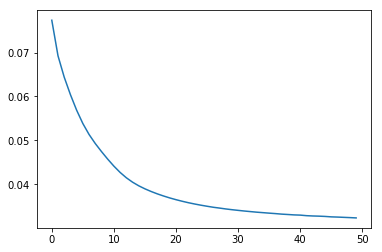

In [9]:
plt.plot(history.history["loss"], label="GRU")
plt.show()

The loss is "stable" even if it didn't reached yet the best point. We can also take a look to the output based on the X_val we generated

In [10]:
print("Input :")
print(X_val)
print("\n\n Output :")
y_pred = model.predict(X_val)
print(y_pred)

Input :
[[[1 0 0 0 0 0 0]
  [0 0 0 0 1 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 1 0 0 0 0]
  [0 0 1 0 0 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 1 0 0 0 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


 Output :
[[[ 0.004  0.462 -0.119  0.054  0.437 -0.097 -0.187]
  [ 0.85   0.127 -0.103 -0.048  0.013  0.089  0.07 ]
  [ 0.031  0.719  0.097 -0.063  0.5    0.075 -0.077]
  [ 0.034  0.062  0.532  0.246 -0.004  0.07   0.012]
  [ 0.024 -0.003  0.603  0.323  0.008  0.06   0.022]
  [ 0.016 -0.035  0.638  0.359  0.007  0.048  0.03 ]
  [-0.035  0.053  0.119  0.855  0.077  0.023  0.045]
  [ 0.019  0.569  0.013 -0.018 -0.012  0.392  0.02 ]
  [-0.042  0.5

We can also perform the cleaning and compare it to the expected output

In [11]:
y_pred = np.where(y_pred < 0.1, 0, y_pred)

In [12]:
for pred, real in zip(y_pred[0], y_possible[0]):
    print(pred, "\t", real)

[ 0.     0.462  0.     0.     0.437  0.     0.   ] 	 [0 1 0 0 1 0 0]
[ 0.85   0.127  0.     0.     0.     0.     0.   ] 	 [1 0 0 0 0 0 0]
[ 0.     0.719  0.     0.     0.5    0.     0.   ] 	 [0 1 0 0 1 0 0]
[ 0.     0.     0.532  0.246  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.     0.603  0.323  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.     0.638  0.359  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.     0.119  0.855  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.569  0.     0.     0.     0.392  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.567  0.     0.     0.     0.415  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.707  0.325  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.116  0.686  0.     0.     0.288] 	 [0 0 1 1 0 0 0]
[ 0.     0.     0.116  0.     0.     0.     0.623] 	 [0 0 0 0 0 0 1]
[ 0.     0.372  0.     0.     0.582  0.     0.274] 	 [0 0 0 0 1 0 0]
[ 0.     0.     0.     0.     0.     0.     0.703] 	 [0 0 0 0 0 0 1]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0

We can see that the output is clearly more "shuffled". This model starts to show it's own limit. We can check the output on the generation of words

In [13]:
def is_embedded_word(w):
    if w[:2] not in ["BT", "BP"]:
        return False
    if reber.in_grammar(w[2:-1]):
        return False
    if w[-1] not in ["T", "P"]:
        return False
    return True

def Pick_From_Output(x):
    y = np.zeros_like(x)
    x = np.where(x < 0.1, 0, x)
    x = x[0]/x[0].sum(axis=1)
    i = np.random.choice(list(range(7)), size=1, p=x[0])
    y[0,0,i] = 1
    return y

def evaluate(model, nb_word = 1, max_iter = 50):
    good_pred = 0
    for _ in range(nb_word):
        model.reset_states()
        first_input = np.array([[[1,0,0,0,0,0,0]]])
        word = "B"
        loop = 0
        nextLetter = "B"
        next_seq = first_input
        while nextLetter != "E" and loop < max_iter:
            y_pred = model.predict(next_seq)
            next_seq = Pick_From_Output(y_pred)
            nextLetter = reber.sequenceToWord(next_seq[0])
            loop += 1
            word += nextLetter
        if is_embedded_word(word):
            good_pred += 1
    acc = 100*good_pred/nb_word
    print("Good prediction : {:.2f}%".format(acc))
    return acc

In [14]:
newModel = Sequential()
newModel.add(GRU(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(model.get_weights())
newModel.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

In [15]:
# start = time.time()
# history2 = newModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nb_epoch, batch_size=batch_size)
# stop = time.time()
# t2 = stop-start
# print(newModel.summary(), end=" ")
# print("Training time : {:}s".format(t2))

In [16]:
result_GRU = []
for _ in range(20):
    result_GRU.append(evaluate(newModel, 100, 50))

Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 1.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%


The output is really worse than it was previously. This is due to the more complexe rule behind the embedded words

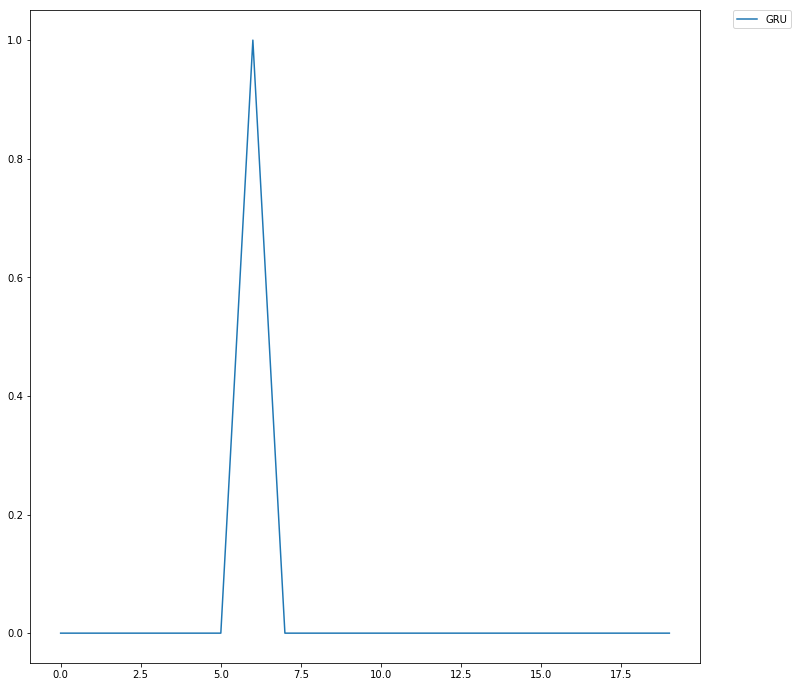

In [17]:
x = list(range(20))
y = [result_GRU]
labels = ["GRU"]

plt.figure(figsize=(12, 12))
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Improvements

Now let's do the same but with differents topology and features

In [18]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "mean_squared_error"
metrics_ = "mean_squared_error"
optimizer_ = "Nadam"
nb_epoch = 50
batch_size = 64

In [19]:
model = Sequential()
model.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=nb_unit, return_sequences=True))
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 30, 7)             315       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 7)             0         
_________________________________________________________________
gru_4 (GRU)                  (None, 30, 7)             315       
Total params: 630
Trainable params: 630
Non-trainable params: 0
_________________________________________________________________
None Training time : 76.4886372089386s


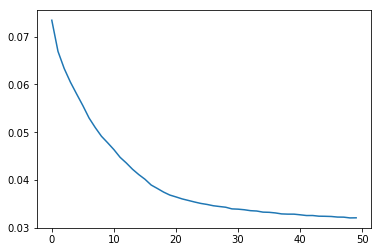

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nb_epoch, batch_size=batch_size, verbose=0)
stop = time.time()
t = stop-start
print(model.summary(), end=" ")
print("Training time : {:}s".format(t))
plt.plot(history.history["loss"], label="GRU")

In [ ]:
newModel = Sequential()
newModel.add(GRU(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.add(GRU(units=nb_unit, return_sequences=True))
newModel.set_weights(model.get_weights())

result_GRU = []
for _ in range(20):
    result_GRU.append(evaluate(newModel, 100, 50))

plt.plot(list(range(20)), result_GRU)
plt.show()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 1.00%
Good prediction : 0.00%
Good prediction : 0.00%
Good prediction : 0.00%


## Conclusion

IUn this workbook, we started to go through RNN. We check simple model of both LSTM, GRU and SimpleRNN to check how fast and well they learn. On this example GRU outperform other models for 2 reasons:
<li>LSTM are better for long sequence memory. On this short example, the generator jumped from a node to another one with the same letter (see red arrow below) <img src="reber_jump.png"/>. In fact, it outputs a too high probability of those non-allowed rules and the "PickOne" function had risks to pick it</li>
<li>Simple RNN are not strong enougth with 1 hidden layer to "remember" all those rules. We need a longer NN which is also longer to train. This simpleRNN is faster but nearly never used anymore as it perform very poorly on lot of cases</li>

## Going further

On a future notebook, we will explore Embedded Reber but using deeper RNNs